# Formula1 Qualifying Prediction Which Telemetry Features are Important?

Author : Ben Palmer\
Date : 02/11/2022

# Summary:


# Introduction:

The aim of this notebook is to test the features that were generated on the sample telemetry data in [4_Formula1_telemetrydata_aggregation](./4_Formula1_telemetrydata_aggregation.ipynb). Are they useful in the prediction of the Target Variables:
- Qualifying Position
- Lap Time Delta

If they are good features we can then proceed to download all the data from 2018 to 2022 and run the feature aggregation pipeline for all the laps in all the Qualifying sessions.



# Table of Contents:

1. [Explortory Analysis on new features](#eda)
    1.1 [Load the Data](#load)
    1.2 [Evaluate & Bin the Target Variables](#bin)
    1.3 [Evaluate Numerical Variables](#num)
    1.4 [Evaluate Categorical Variables](#cat)

2. [Prepare Data for modelling](#prep)
    2.1 [Feature Engineer Country](#country)
    2.2 [Test Train Split](#testrain)
    2.3 [Feature Engineer Categorical Variables](#onehot)
    2.4 [Label Target Variables](#label)

3. [Feature Importance](#feature)
    3.1 [Random Forest Feature Importance](#rf)
    3.2 [Select K Best](#kbest)
    3.3 [Principal Component Analysis](#pca)
    3.4 [Summary of Feature Importance](#sumfeature)

4. [Summary](#sum)

5. [Next Steps](#steps)

6. [Appendix](#appendix)





### Imports

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scripts import ds_ultils
import plotly.express as px
from scripts.f1_ultils import *
from scripts.ds_ultils import *
plt.style.use('./scripts/plotstyle.mplstyle')
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import accuracy_score

# Exploratory Analysis on the new features 
<a id="eda"></a>

## Load data
<a id="load"></a>

In [2]:
qualifying_data=pd.read_csv('./data/model_data/formula1_2018_2019_5GP_aggregated.csv')

In [3]:
qualifying_df= qualifying_data.copy()

In [4]:
qualifying_df.head(5)

raceId driverRef circuitRef country nationality_drivers constructorRef  \
0     993    alonso  catalunya   Spain               Spain        mclaren   
1     993    bottas  catalunya   Spain             Finland       mercedes   
2     993  ericsson  catalunya   Spain              Sweden         sauber   
3     993     gasly  catalunya   Spain              France     toro_rosso   
4     993  grosjean  catalunya   Spain              France           haas   

  nationality_constructors    year  lat_x    lng_x  ...  avglap_Sector1  \
0                       UK  2018.0  41.57  2.26111  ...       22.835222   
1                  Germany  2018.0  41.57  2.26111  ...       23.765333   
2              Switzerland  2018.0  41.57  2.26111  ...       24.981800   
3                    Italy  2018.0  41.57  2.26111  ...       23.887500   
4                      USA  2018.0  41.57  2.26111  ...       23.728071   

   avglap_Sector2  avglap_Sector3  fastestlap_percentagerainfall  \
0       30.568444       28.153444                          100.0   
1       31.612500       30.362000                          100.0   
2       36.156200       30.434600                            0.0   
3       32.403125       29.813000                          100.0   
4       32.493429       29.558929                          100.0   

   fastestlap_track_temperature  fastestlap_humidity  \
0                          26.4                 79.2   
1                          26.4                 79.2   
2                          27.6                 76.1   
3                          26.8                 77.8   
4                          27.1                 77.1   

   avg_lap_percentagerainfall  avg_lap_track_temperature  avg_lap_humidty  \
0                       100.0                  27.255556        77.311111   
1                       100.0                  26.950000        77.883333   
2                         0.0                  27.620000        76.440000   
3                       100.0                  27.462500        76.587500   
4                       100.0                  27.135714        77.350000   

   fastest_lap_milliseconds_clean  
0                         77721.0  
1                         76213.0  
2                         79493.0  
3                         78463.0  
4                         77699.0  

[5 rows x 102 columns]

Position, wins and points are all after the event as happened so they are indirect predictions. Therefore they need to be removed. Later we may feature engineer average position that season, and average results leading up to the race but first we need to remove that and define our targets

## Drop addittional prediction features

In [5]:
qualifying_df.drop(columns=['positionOrder',
 'points',
 'points_drivers',
 'position_drivers',
 'wins_drivers',
 'points_constructors',
 'position_constructors',
 'wins_constructors',
 'points_constructor_ind_races'],axis=1,inplace=True)

In [6]:
#drop id column
qualifying_df.drop(columns=['qualifyId'],axis=1,inplace=True)

## Evaluate & Bin Target variables
<a id="bin"></a>

We are aiming to prediction qualifying position and time

<AxesSubplot: xlabel='quali_position', ylabel='Count'>

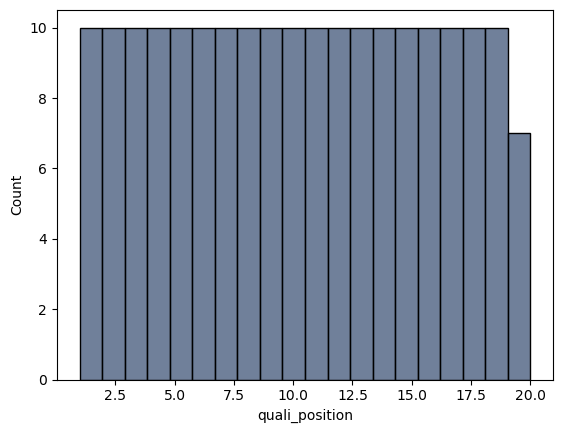

In [8]:
sns.histplot(data = qualifying_df ,x='quali_position',bins=20)

In [9]:
qualifying_df['fastest_lap_milliseconds'].describe()

count      197.000000
mean     76953.472081
std       9766.507890
min      63003.000000
25%      71232.000000
50%      76588.000000
75%      78782.000000
max      99197.000000
Name: fastest_lap_milliseconds, dtype: float64

<AxesSubplot: xlabel='fastest_lap_milliseconds', ylabel='Count'>

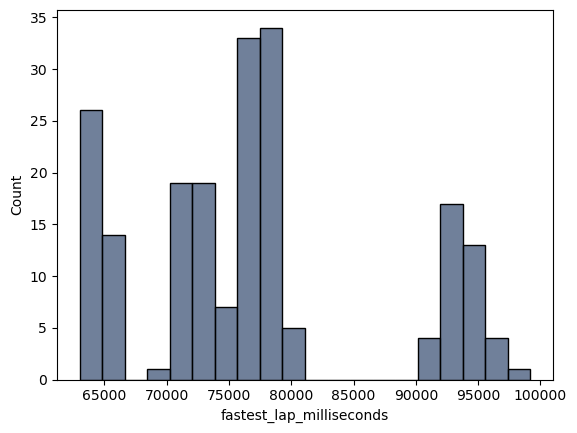

In [10]:
sns.histplot(data = qualifying_df ,x='fastest_lap_milliseconds',bins=20)

### Qualifying Position


In [11]:
qualifying_df['quali_position_binned'] = pd.cut(qualifying_df['quali_position'],bins=4,labels=['0_to_5','5_to_10','eleven_to_15','fifteen_&_above'])

<AxesSubplot: xlabel='quali_position_binned', ylabel='Count'>

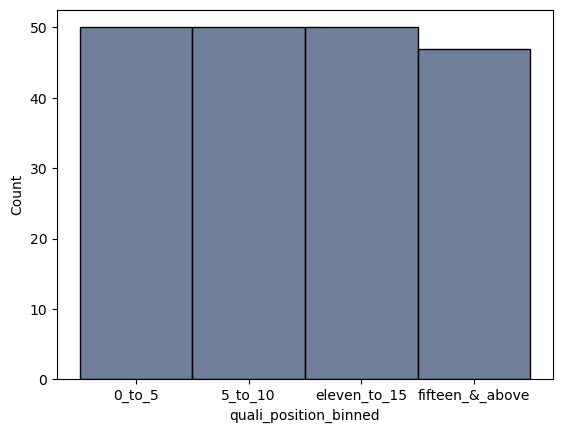

In [12]:
sns.histplot(data = qualifying_df ,x='quali_position_binned',bins=20)

In [13]:
races = qualifying_df['raceId'].unique()
for race in races:
    query = (qualifying_df['raceId'] == race)
    fastesttime= qualifying_df.loc[(query) & (qualifying_df['quali_position'] == 1),'fastest_lap_milliseconds'].values
    
    qualifying_df.loc[query,'lap_timedelta_milliseconds']=(np.where(qualifying_df.loc[query,'quali_position']==1,0,(fastesttime-qualifying_df.loc[query,'fastest_lap_milliseconds'])))

In [14]:
qualifying_df['lap_timedelta_milliseconds'].describe()

count     197.000000
mean    -1647.538071
std      1182.851464
min     -7569.000000
25%     -2236.000000
50%     -1558.000000
75%      -850.000000
max       753.000000
Name: lap_timedelta_milliseconds, dtype: float64

In [15]:
query = (qualifying_df['circuitRef']== 'hungaroring') & (qualifying_df['year'] == 2018)
qualifying_df.loc[query,['quali_position','lap_timedelta_milliseconds','fastest_lap_milliseconds','fastest_lap_milliseconds_clean']]

quali_position  lap_timedelta_milliseconds  fastest_lap_milliseconds  \
58            11.0                      -789.0                   78208.0   
59             2.0                       296.0                   77123.0   
60             8.0                     -1010.0                   78429.0   
61            14.0                     -1222.0                   78641.0   
62             6.0                     -1158.0                   78577.0   
63            10.0                      -482.0                   77901.0   
64             1.0                         0.0                   77419.0   
65            13.0                      -486.0                   77905.0   
66             9.0                      -895.0                   78314.0   
67            17.0                     -1398.0                   78817.0   
68             7.0                       479.0                   76940.0   
69            18.0                     -1723.0                   79142.0   
70            19.0                     -1781.0                   79200.0   
71             3.0                      -107.0                   77526.0   
72            12.0                     -1121.0                   78540.0   
73             5.0                      -410.0                   77829.0   
74            20.0                     -1882.0                   79301.0   
75            15.0                     -1141.0                   78560.0   
76            16.0                     -1363.0                   78782.0   
77             4.0                       753.0                   76666.0   

    fastest_lap_milliseconds_clean  
58                         78208.0  
59                         77123.0  
60                         78429.0  
61                         78641.0  
62                         78577.0  
63                         77901.0  
64                         77419.0  
65                         77905.0  
66                         78314.0  
67                         78817.0  
68                         76940.0  
69                         79142.0  
70                         79200.0  
71                         77526.0  
72                         78540.0  
73                         77829.0  
74                         79301.0  
75                         78560.0  
76                         78782.0  
77                         76666.0

In [16]:
ergast_combined_df=pd.read_csv('./data/clean/combined_ergast_clean.csv')

In [17]:
ergast_combined_df.loc[ergast_combined_df['raceId']==1000,['q2','q3']]

q2        q3
3911  1:32.762  1:36.186
3912  1:28.636  1:36.210
3913  1:30.771  1:36.743
3914  1:31.286  1:37.591
3915  1:31.178  1:38.032
3916  1:32.590  1:38.128
3917  1:32.968  1:39.858
3918  1:33.650  1:40.593
3919  1:35.214       NaN
3920  1:36.442       NaN
3921  1:36.506       NaN
3922  1:37.075       NaN
3923       NaN       NaN
3924       NaN       NaN
3925       NaN       NaN
3926       NaN       NaN
3927       NaN       NaN
3928       NaN       NaN
3929  1:31.242  1:35.658
3930  1:32.081  1:35.918

Need to go back to fix q3 times overwritten by q2 times when slower to preserve format

<AxesSubplot: xlabel='lap_timedelta_milliseconds', ylabel='Count'>

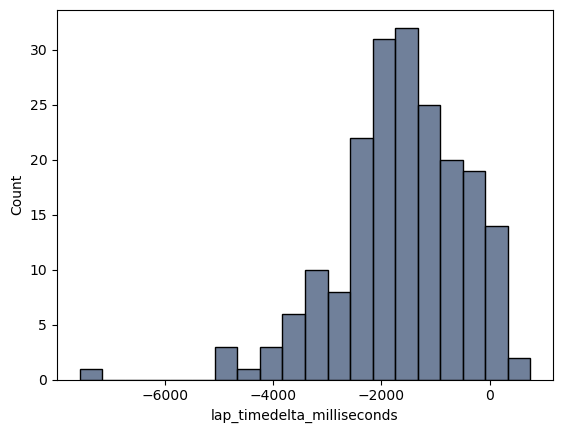

In [18]:
sns.histplot(data = qualifying_df ,x='lap_timedelta_milliseconds',bins=20)


Temp fix cut of values above 0

In [19]:
qualifying_df['lap_timedelta_milliseconds'] = np.where(qualifying_df['lap_timedelta_milliseconds'] >0,0,qualifying_df['lap_timedelta_milliseconds'])

In [20]:
qualifying_df['lap_timedelta_milliseconds'].describe()

count     197.000000
mean    -1655.294416
std      1169.990783
min     -7569.000000
25%     -2236.000000
50%     -1558.000000
75%      -850.000000
max         0.000000
Name: lap_timedelta_milliseconds, dtype: float64

### Lap Time Delta

In [20]:
qualifying_df['lap_timedelta_seconds_binned'] = pd.qcut(qualifying_df['lap_timedelta_milliseconds'],q=4,labels=['>2.2s','2.2-1.5s','1.5-0.8s','0.8-0s'])

<AxesSubplot: xlabel='lap_timedelta_seconds_binned', ylabel='Count'>

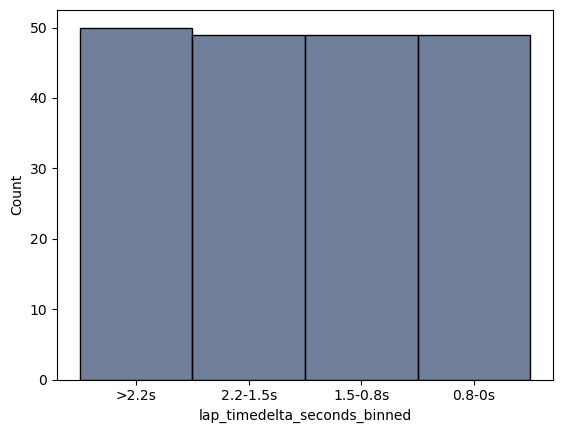

In [21]:
sns.histplot(data = qualifying_df ,x='lap_timedelta_seconds_binned',bins=20)

## Evaluate Numerical Variables
<a id="num"></a>

In [22]:
variables_explore(qualifying_df)


Dataframe numeric columns: 
 raceId,
year,
lat_x,
lng_x,
alt,
quali_position,
age,
fastest_lap_milliseconds,
circuit_length,
circuit_total_straight,
circuit_mean_straight,
circuit_max_straight,
circuit_total_corner_length,
circuit_mean_corner_length,
circuit_max_corner_length,
circuit_total_corner_curvature,
circuit_mean_corner_curvature,
circuit_max_corner_curvature,
circuit_std_corner_curvature,
circuit_number_of_corners,
max_max_speed,
max_fastest_lap_speed,
var_fastest_lap_speed,
min_fastest_lap_speed,
max_lap_speed,
var_lap_speed,
bottom_lap_speed,
mean_straight_speed,
var_straight_speed,
max_fastest_accleration,
var_fastest_accleration,
min_fastest_accleration,
mean_top_lap_accleration,
mean_var_lap_accleration,
mean_min_lap_accleration,
max_fastest_lap_rpm,
var_fastest_lap_straight_rpm,
mean_fastest_lap_straight_rpm,
max_max_rpm,
mean_var_straight_rpm,
mean_straight_rpm,
avg_gear1_time,
avg_gear2_time,
avg_gear3_time,
avg_gear4_time,
avg_gear5_time,
avg_gear6_time,
avg_gear7_ti

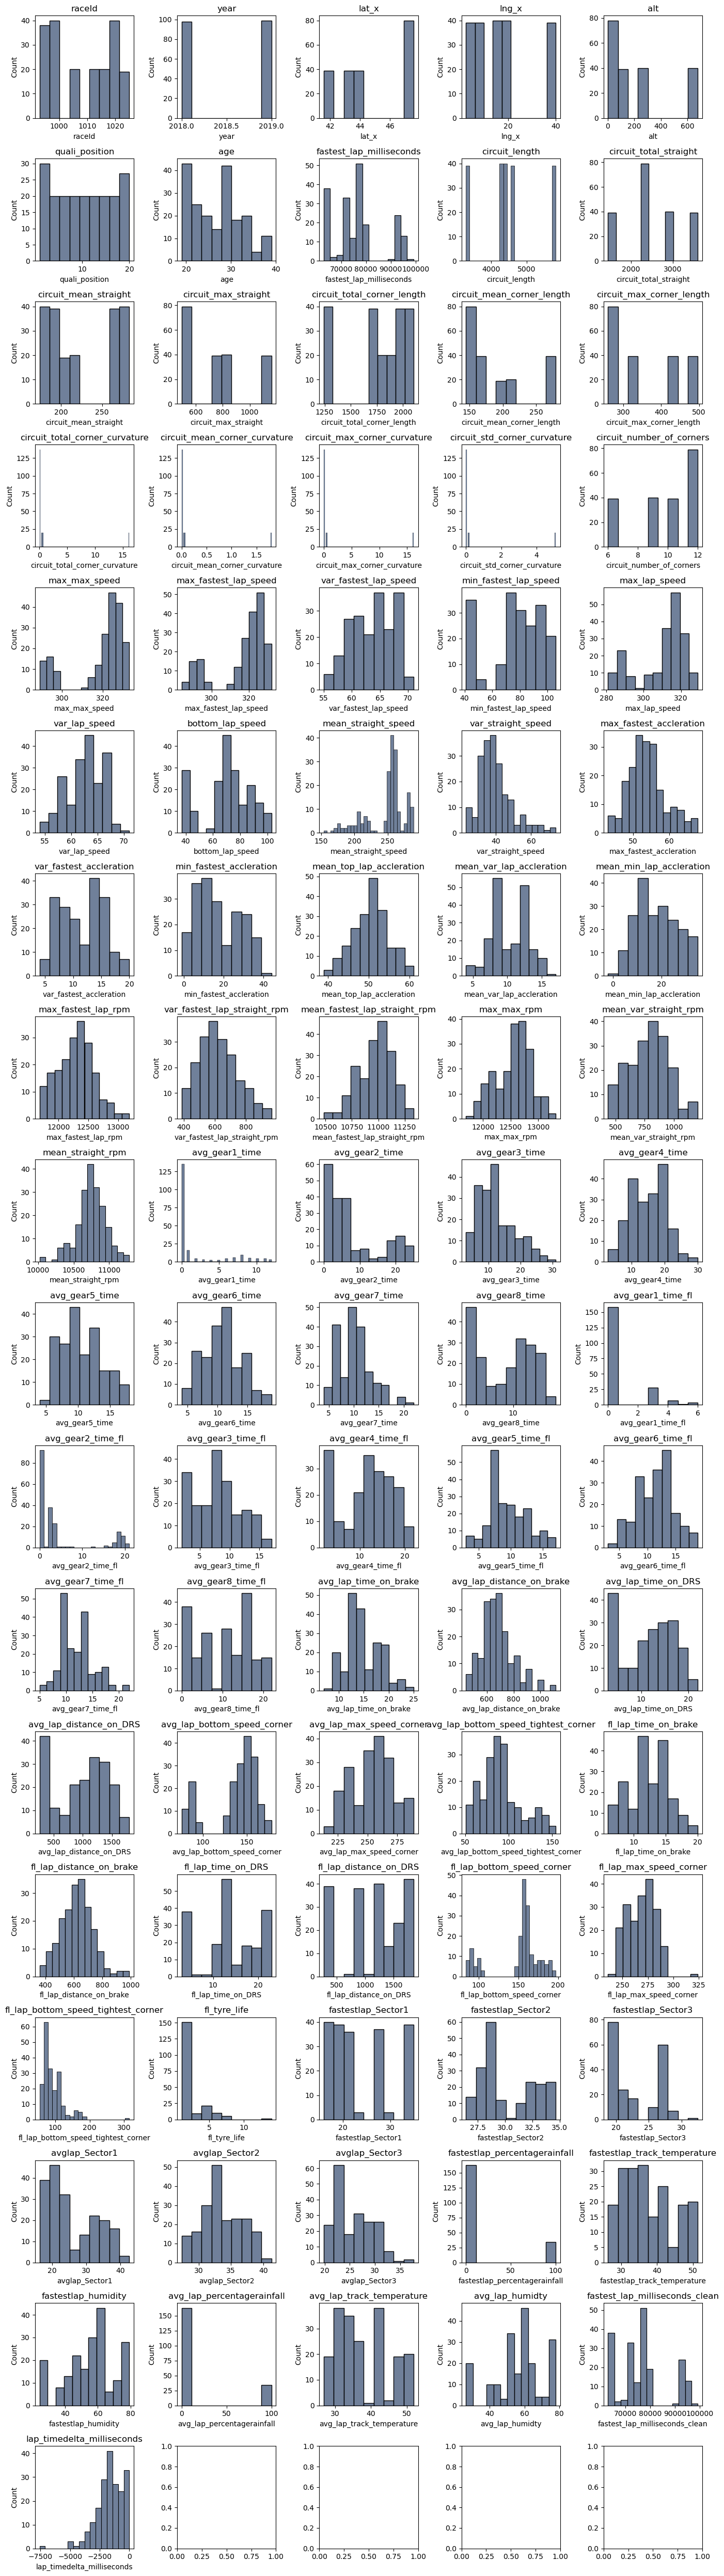

In [23]:
plot_numerical_variables_hist(qualifying_df)

## Evaluate Categorical Variables
<a id="cat"></a>

In [24]:
cat_list = list(qualifying_df.select_dtypes("object").columns)+list(qualifying_df.select_dtypes("category").columns)

In [25]:
def plot_categorical_cols_by_dim(df,dim,columns=5,**kwargs):
    figsize=(14,12)
    cat_list = list(df.select_dtypes("object").columns)+list(df.select_dtypes("category").columns)
    fig,axes=plt.subplots(math.ceil(len(df[cat_list].columns)/columns), columns, figsize=figsize)
    for col,axes in zip(df[cat_list].columns,axes.flatten()):
        total_count = df.groupby([col, dim])[col].count()
        pct_contact_type = total_count/df.groupby(col)[col].count()
        pct_contact_type = pct_contact_type.unstack()
        #print(pct_contact_type)
        #print(pct_contact_type.sort_values())    
        pct_contact_type.plot(kind="bar", stacked=True, ax=axes)
        sns.despine(left=True)
        axes.set_title(f"{col} group distribution", size=10)
    plt.tight_layout()
    plt.show()

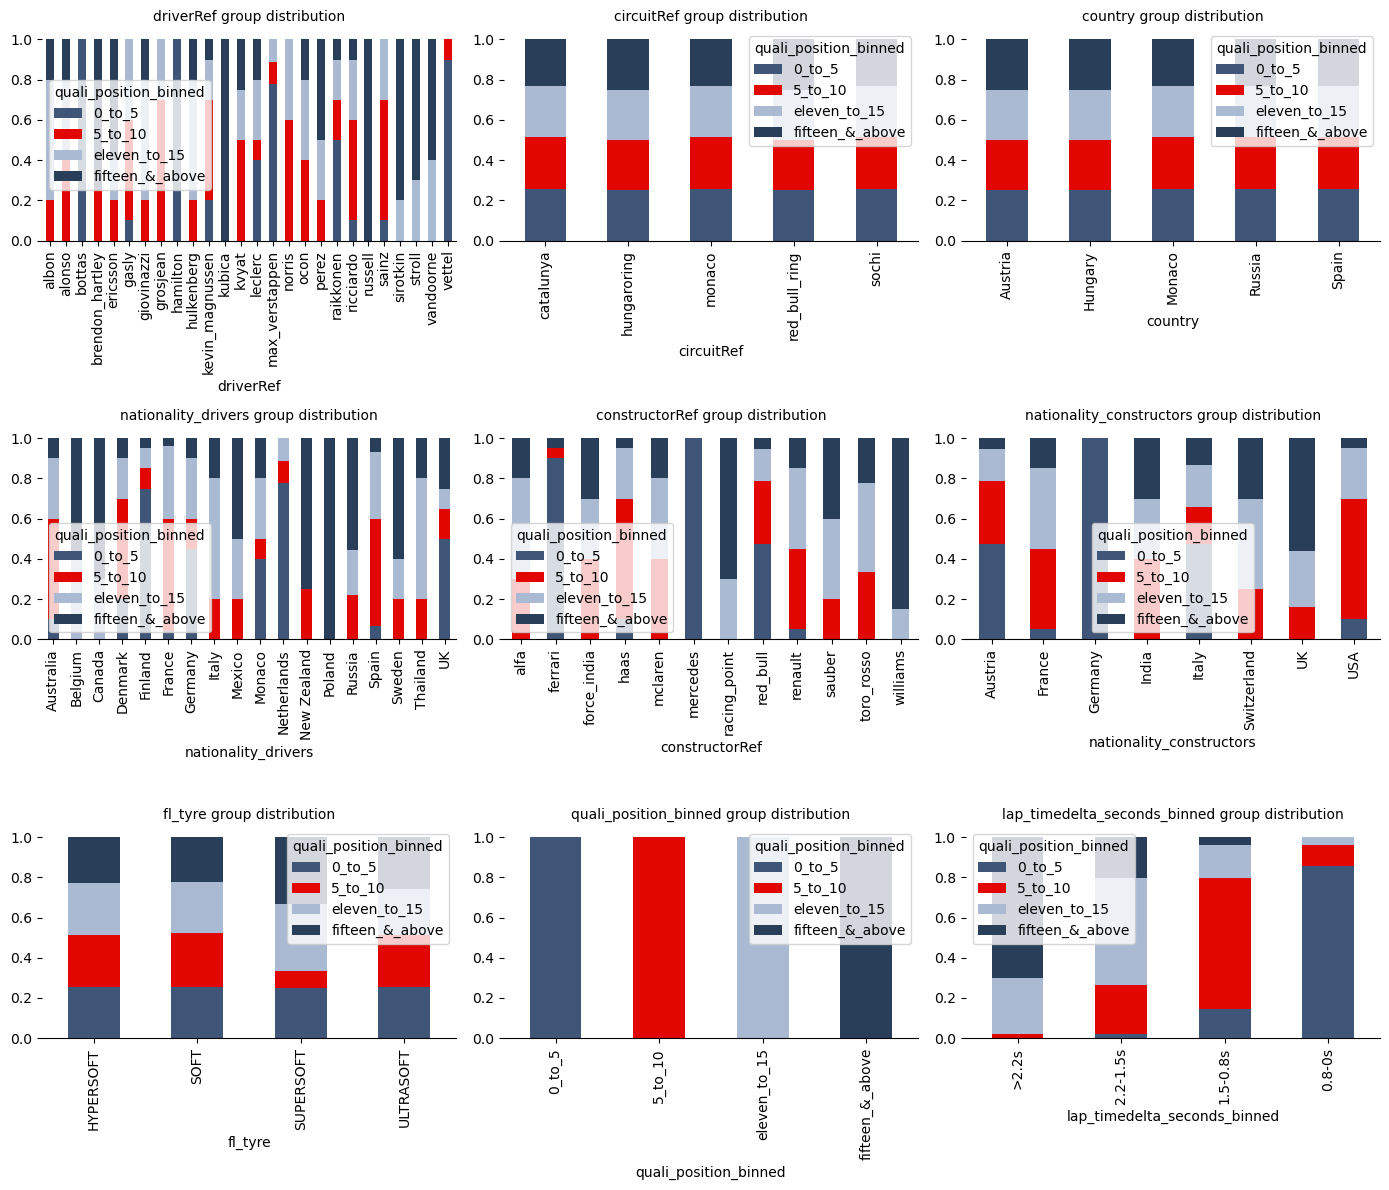

In [26]:
plot_categorical_cols_by_dim(qualifying_df,'quali_position_binned',columns=3)

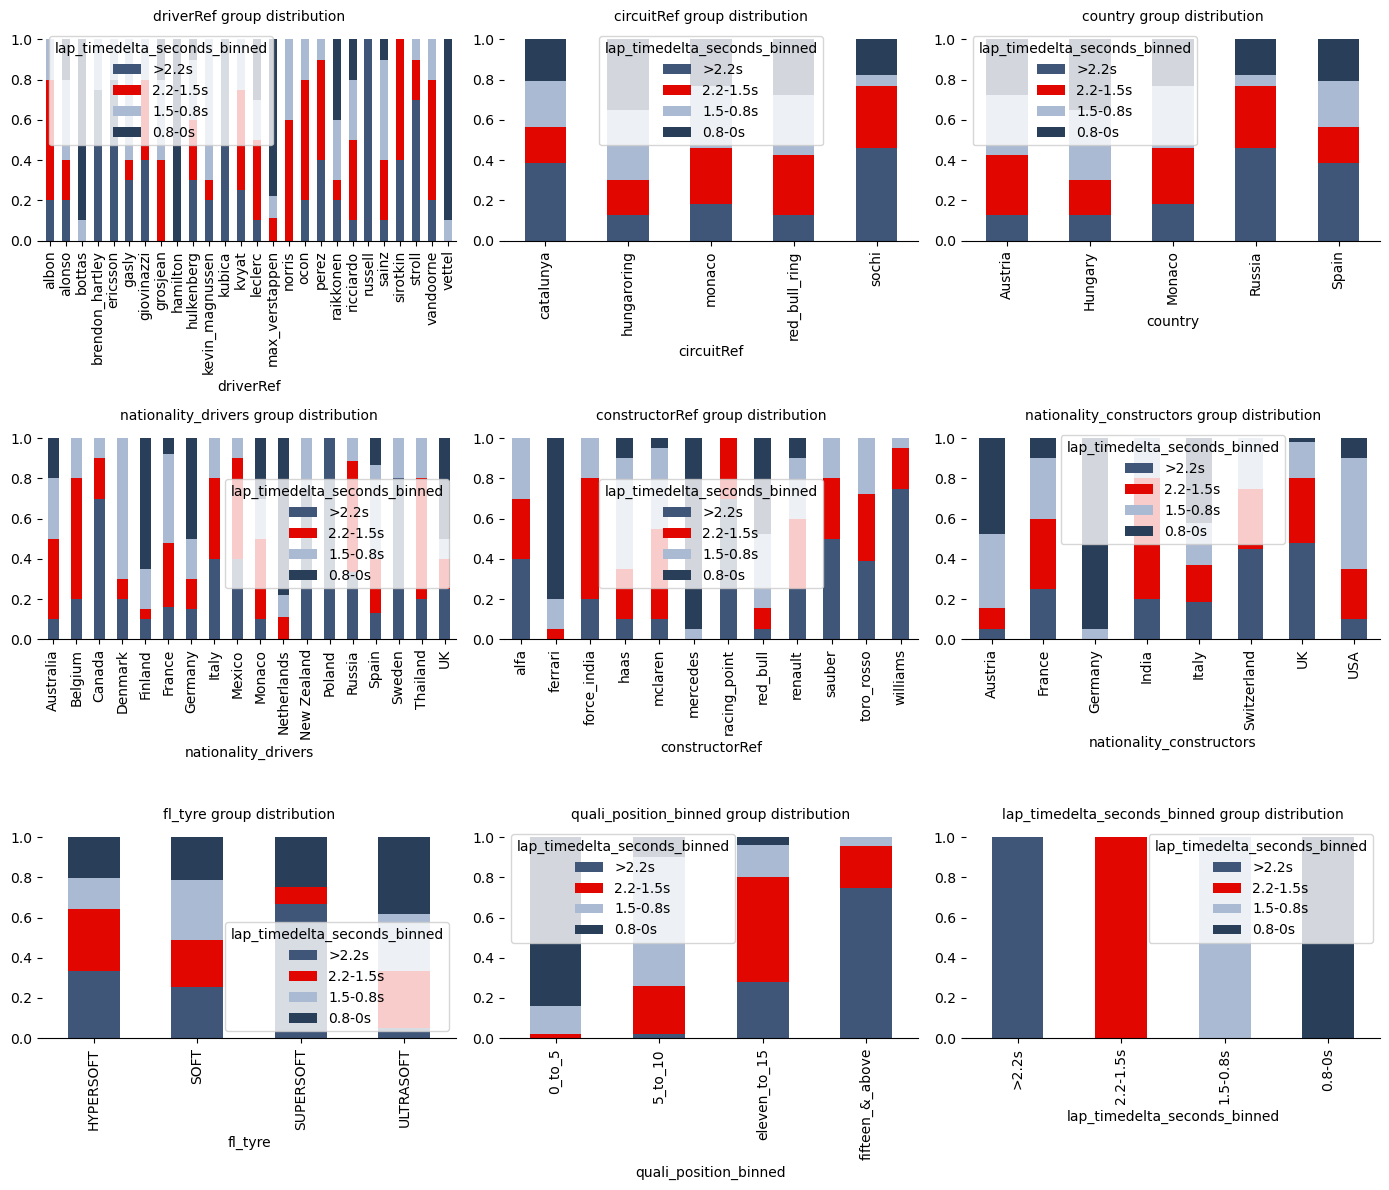

In [27]:
plot_categorical_cols_by_dim(qualifying_df,'lap_timedelta_seconds_binned',columns=3)

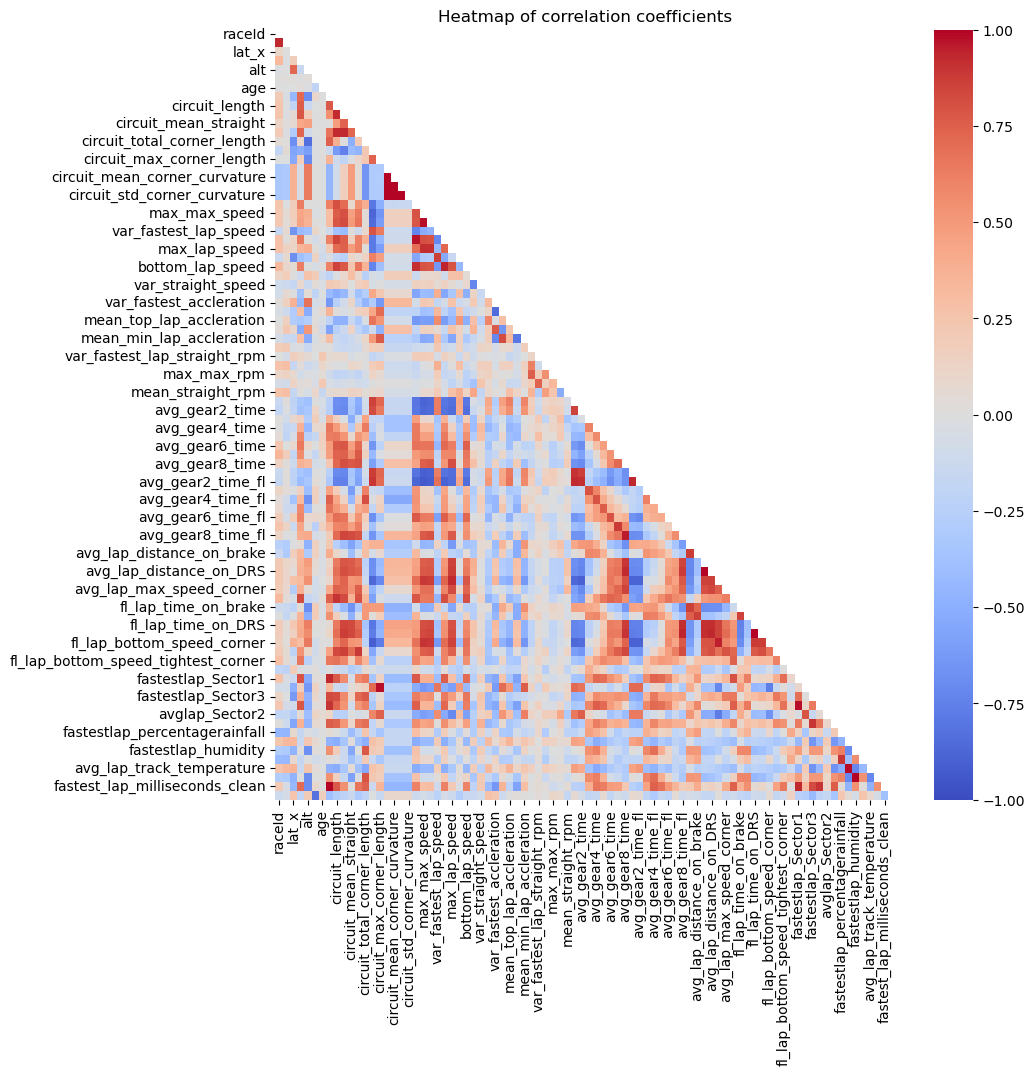

-------------------------------
VIF test results


c:\Users\ben44\.conda\envs\Formula1\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
c:\Users\ben44\.conda\envs\Formula1\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Variation Inflation Factor : 
 raceId                                    inf
year                                      inf
lat_x                                     inf
lng_x                                     inf
alt                                       inf
                                     ...     
avg_lap_percentagerainfall           8.550628
avg_lap_track_temperature         1091.917154
avg_lap_humidty                    745.958006
fastest_lap_milliseconds_clean            inf
lap_timedelta_milliseconds         503.311420
Length: 86, dtype: float64
-----------------------------------


In [28]:
independence_test(qualifying_df,qualifying_df.select_dtypes("number").columns,annot=False)

### Linearity

Pearsonsr Statistical Correlation Test:
-----------------
raceId pearsonsr correlation test against quali_position : 
 PearsonRResult(statistic=0.009475774375959294, pvalue=0.8948613600493237)

year pearsonsr correlation test against quali_position : 
 PearsonRResult(statistic=0.008606279374697861, pvalue=0.9044606530793701)

lat_x pearsonsr correlation test against quali_position : 
 PearsonRResult(statistic=0.01993116766575037, pvalue=0.781016474717891)

lng_x pearsonsr correlation test against quali_position : 
 PearsonRResult(statistic=0.00036720819834713814, pvalue=0.995913880469354)

alt pearsonsr correlation test against quali_position : 
 PearsonRResult(statistic=0.017651434152185872, pvalue=0.8055334201434863)

quali_position pearsonsr correlation test against quali_position : 
 PearsonRResult(statistic=1.0, pvalue=0.0)

age pearsonsr correlation test against quali_position : 
 PearsonRResult(statistic=-0.19849463618642937, pvalue=0.005171492946783412)

fastest_lap_millisecond

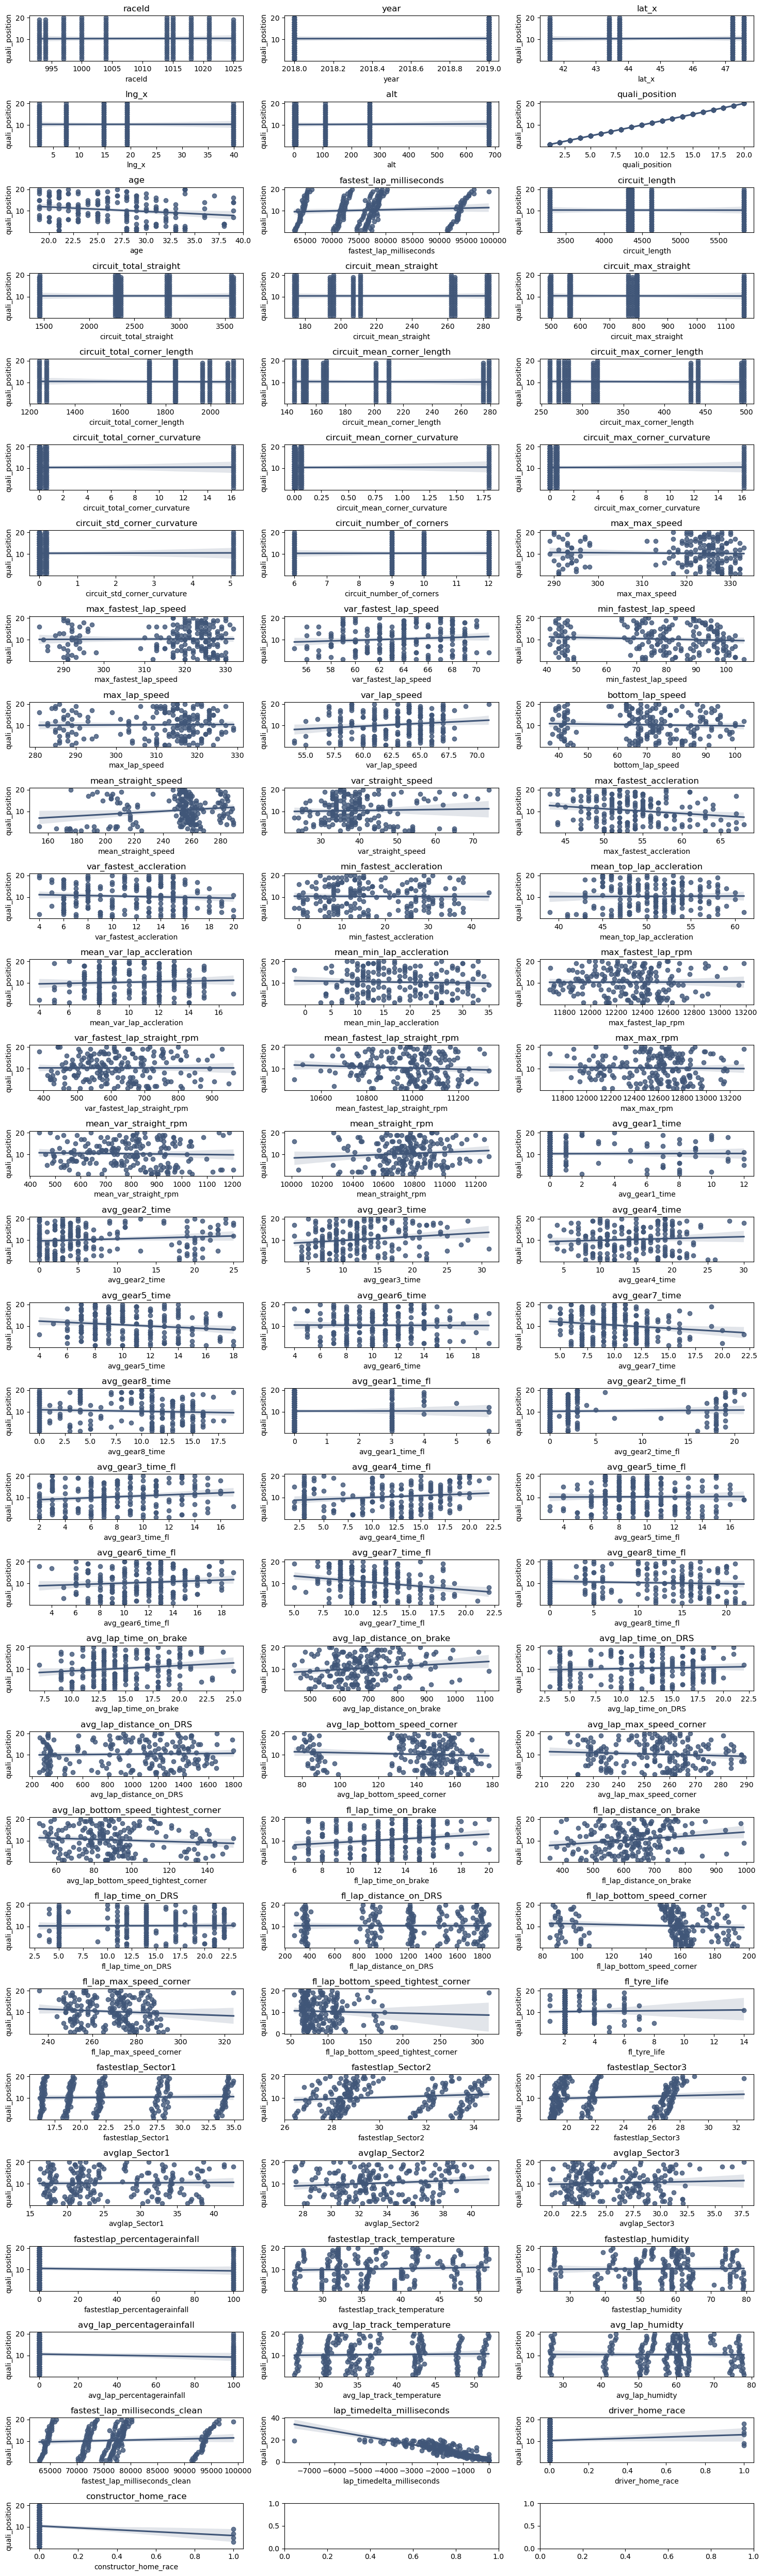

In [51]:
num_col=qualifying_df.select_dtypes("number").columns
correlation_test(qualifying_df,num_col,'quali_position',figsize=(15,50))

# Prepare Data for Modelling
<a id="prep"></a>

## Feature Engineer Country Variables
<a id="country"></a>

In [29]:
qualifying_df['driver_home_race']=np.where(qualifying_df['country'] == qualifying_df['nationality_drivers'],1,0)

In [30]:
qualifying_df['constructor_home_race']= np.where(qualifying_df['country'] == qualifying_df['nationality_constructors'],1,0)

## Train Test split
<a id="testrain"></a>

In [31]:
query =(qualifying_df['circuitRef'].isin(['hungaroring','sochi'])) &(qualifying_df['year']==2019)
X_test = qualifying_df[query].drop(columns=['fastest_lap_milliseconds','fastest_lap_milliseconds_clean', 'lap_timedelta_milliseconds','quali_position','raceId']).copy()
X_train = qualifying_df[~query].drop(columns=['fastest_lap_milliseconds','fastest_lap_milliseconds_clean', 'lap_timedelta_milliseconds','quali_position','raceId']).copy()
y_test=qualifying_df.loc[query,['lap_timedelta_seconds_binned','quali_position_binned']]
y_train=qualifying_df.loc[~query,['lap_timedelta_seconds_binned','quali_position_binned']]

In [32]:
len(X_test)

39

In [33]:
len(X_train)

158

In [34]:
X_train.head()

driverRef circuitRef country nationality_drivers constructorRef  \
0    alonso  catalunya   Spain               Spain        mclaren   
1    bottas  catalunya   Spain             Finland       mercedes   
2  ericsson  catalunya   Spain              Sweden         sauber   
3     gasly  catalunya   Spain              France     toro_rosso   
4  grosjean  catalunya   Spain              France           haas   

  nationality_constructors    year  lat_x    lng_x    alt  ...  \
0                       UK  2018.0  41.57  2.26111  109.0  ...   
1                  Germany  2018.0  41.57  2.26111  109.0  ...   
2              Switzerland  2018.0  41.57  2.26111  109.0  ...   
3                    Italy  2018.0  41.57  2.26111  109.0  ...   
4                      USA  2018.0  41.57  2.26111  109.0  ...   

   fastestlap_percentagerainfall  fastestlap_track_temperature  \
0                          100.0                          26.4   
1                          100.0                          26.4   
2                            0.0                          27.6   
3                          100.0                          26.8   
4                          100.0                          27.1   

   fastestlap_humidity  avg_lap_percentagerainfall  avg_lap_track_temperature  \
0                 79.2                       100.0                  27.255556   
1                 79.2                       100.0                  26.950000   
2                 76.1                         0.0                  27.620000   
3                 77.8                       100.0                  27.462500   
4                 77.1                       100.0                  27.135714   

   avg_lap_humidty  quali_position_binned  lap_timedelta_seconds_binned  \
0        77.311111                5_to_10                      1.5-0.8s   
1        77.883333                 0_to_5                        0.8-0s   
2        76.440000        fifteen_&_above                         >2.2s   
3        76.587500           eleven_to_15                         >2.2s   
4        77.350000                5_to_10                      1.5-0.8s   

   driver_home_race  constructor_home_race  
0                 1                      0  
1                 0                      0  
2                 0                      0  
3                 0                      0  
4                 0                      0  

[5 rows x 92 columns]

## Feature Enginer Categorical Variables
<a id="onehot"></a>

In [36]:
encoder=OneHotEncoder()
encoder.fit(X_train['driverRef'].values.reshape(-1,1))
X_train_drivers_x= encoder.transform(X_train['driverRef'].values.reshape(-1,1))
X_test_drivers_x=encoder.transform(X_test['driverRef'].values.reshape(-1,1))
X_train_drivers_df =pd.DataFrame(data=X_train_drivers_x.toarray(),columns=encoder.get_feature_names_out())
X_test_drivers_df =pd.DataFrame(data=X_test_drivers_x.toarray(),columns=encoder.get_feature_names_out())

In [37]:
encoder=OneHotEncoder()
encoder.fit(X_train['circuitRef'].values.reshape(-1,1))
X_train_circuit_x= encoder.transform(X_train['circuitRef'].values.reshape(-1,1))
X_train_circuit_df =pd.DataFrame(data=X_train_circuit_x.toarray(),columns=encoder.get_feature_names_out())
X_test_circuit_x= encoder.transform(X_test['circuitRef'].values.reshape(-1,1))
X_test_circuit_df =pd.DataFrame(data=X_test_circuit_x.toarray(),columns=encoder.get_feature_names_out())



In [38]:
encoder=OneHotEncoder()
encoder.fit(X_train['constructorRef'].values.reshape(-1,1))
cons_x= encoder.transform(X_train['constructorRef'].values.reshape(-1,1))
X_train_cons_df =pd.DataFrame(data=cons_x.toarray(),columns=encoder.get_feature_names_out())
X_test_cons_x= encoder.transform(X_test['constructorRef'].values.reshape(-1,1))
X_test_cons_df =pd.DataFrame(data=X_test_cons_x.toarray(),columns=encoder.get_feature_names_out())

In [39]:
encoder=OneHotEncoder()
encoder.fit(X_train['constructorRef'].values.reshape(-1,1))
cons_x= encoder.transform(X_train['constructorRef'].values.reshape(-1,1))
X_train_cons_df =pd.DataFrame(data=cons_x.toarray(),columns=encoder.get_feature_names_out())
X_test_cons_x= encoder.transform(X_test['constructorRef'].values.reshape(-1,1))
X_test_cons_df =pd.DataFrame(data=X_test_cons_x.toarray(),columns=encoder.get_feature_names_out())

## Label Target Variables
<a id="label"></a>

In [40]:
y_train

lap_timedelta_seconds_binned quali_position_binned
0                       1.5-0.8s               5_to_10
1                         0.8-0s                0_to_5
2                          >2.2s       fifteen_&_above
3                          >2.2s          eleven_to_15
4                       1.5-0.8s               5_to_10
..                           ...                   ...
153                     2.2-1.5s          eleven_to_15
154                        >2.2s       fifteen_&_above
155                     1.5-0.8s          eleven_to_15
156                     2.2-1.5s       fifteen_&_above
157                       0.8-0s               5_to_10

[158 rows x 2 columns]

In [41]:
labelencoder=LabelEncoder()
labelencoder.fit(y_train['lap_timedelta_seconds_binned'])
y1_train= labelencoder.transform(y_train['lap_timedelta_seconds_binned'])
y1_test= labelencoder.transform(y_test['lap_timedelta_seconds_binned'])

In [42]:
labelencoder.classes_

array(['0.8-0s', '1.5-0.8s', '2.2-1.5s', '>2.2s'], dtype=object)

In [43]:
labelencoder=LabelEncoder()
labelencoder.fit(y_train['quali_position_binned'])
y2_train= labelencoder.transform(y_train['quali_position_binned'])
y2_test= labelencoder.transform(y_test['quali_position_binned'])
labelencoder.classes_

array(['0_to_5', '5_to_10', 'eleven_to_15', 'fifteen_&_above'],
      dtype=object)

In [44]:
X_train= pd.concat([X_train.select_dtypes("number"),X_train_cons_df,X_train_circuit_df,X_train_drivers_df],axis=1)
X_test= pd.concat([X_test.select_dtypes("number").reset_index(drop=True),X_test_cons_df,X_test_circuit_df,X_test_drivers_df],axis=1)

In [45]:
# scale data

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

# Feature Importance
<a id="feature"></a>

## Random Forest Feature Importance
<a id="rf"></a>

In [52]:

sel = SelectFromModel(RandomForestClassifier())
sel.fit(X_train_scaled, y1_train)
sel.get_support().sum()

52

In [53]:
X_train.columns[sel.get_support()]

Index(['age', 'max_max_speed', 'max_fastest_lap_speed',
       'min_fastest_lap_speed', 'var_lap_speed', 'bottom_lap_speed',
       'mean_straight_speed', 'var_straight_speed', 'max_fastest_accleration',
       'min_fastest_accleration', 'mean_top_lap_accleration',
       'mean_min_lap_accleration', 'max_fastest_lap_rpm',
       'var_fastest_lap_straight_rpm', 'mean_fastest_lap_straight_rpm',
       'max_max_rpm', 'mean_var_straight_rpm', 'mean_straight_rpm',
       'avg_gear2_time', 'avg_gear3_time', 'avg_gear4_time', 'avg_gear5_time',
       'avg_gear6_time', 'avg_gear7_time', 'avg_gear8_time',
       'avg_gear4_time_fl', 'avg_gear5_time_fl', 'avg_gear6_time_fl',
       'avg_gear7_time_fl', 'avg_gear8_time_fl', 'avg_lap_distance_on_brake',
       'avg_lap_distance_on_DRS', 'avg_lap_bottom_speed_corner',
       'avg_lap_max_speed_corner', 'avg_lap_bottom_speed_tightest_corner',
       'fl_lap_distance_on_brake', 'fl_lap_distance_on_DRS',
       'fl_lap_bottom_speed_corner', 'fl_lap_ma

In [102]:
rf=RandomForestClassifier()
rf_model = rf.fit(X_train_scaled,y1_train)

In [103]:
rf_model.feature_importances_

array([9.59644022e-04, 2.81032151e-03, 6.69227450e-04, 2.92431820e-03,
       1.53200705e-02, 4.38412902e-03, 4.83524789e-03, 3.90390843e-03,
       2.82811505e-03, 1.59956782e-03, 3.44023615e-03, 3.51129825e-03,
       5.95845057e-03, 6.49361787e-03, 5.47065771e-03, 4.35261245e-03,
       9.43398146e-04, 1.01313128e-02, 1.00461013e-02, 6.66556381e-03,
       1.08550862e-02, 1.06097174e-02, 1.15361988e-02, 1.11778222e-02,
       1.63503365e-02, 2.72941604e-02, 9.78984086e-03, 6.77245871e-03,
       9.62400945e-03, 1.31196702e-02, 6.14828241e-03, 9.32648226e-03,
       1.15170271e-02, 1.74885557e-02, 1.28015669e-02, 1.39145397e-02,
       2.94372210e-02, 1.20539082e-02, 2.32193358e-03, 8.50062459e-03,
       1.21297379e-02, 9.50994935e-03, 8.71261949e-03, 8.99150230e-03,
       9.16276370e-03, 7.83507901e-03, 1.08566435e-03, 3.21039572e-03,
       1.10017334e-02, 1.45334961e-02, 7.75277502e-03, 7.41677224e-03,
       8.94441781e-03, 8.88697856e-03, 5.78438498e-03, 1.69458216e-02,
      

In [112]:
y_pred = rf_model.predict(X_test_scaled)

In [113]:


print(accuracy_score(y1_test,y_pred))


0.5384615384615384


In [105]:
RF_results = pd.DataFrame(data=rf_model.feature_importances_ ,index=X_train.columns)

In [106]:
RF_results.rename(columns={0:'Random_forest_result'},inplace=True)

In [107]:
RF_results.sort_values(by='Random_forest_result',ascending=False).head(30)

Random_forest_result
fastestlap_Sector2                                0.076813
fastestlap_Sector3                                0.053068
x0_mercedes                                       0.029693
mean_var_straight_rpm                             0.029437
var_straight_speed                                0.027294
fastestlap_Sector1                                0.024283
avglap_Sector2                                    0.022488
fl_lap_bottom_speed_corner                        0.022121
avglap_Sector3                                    0.021335
avg_lap_track_temperature                         0.018643
var_fastest_lap_straight_rpm                      0.017489
avg_lap_humidty                                   0.017151
avg_lap_distance_on_brake                         0.016946
mean_straight_speed                               0.016350
age                                               0.015320
fl_lap_distance_on_DRS                            0.014885
avg_gear4_time_fl                                 0.014533
avg_lap_bottom_speed_tightest_corner              0.014203
fl_lap_bottom_speed_tightest_corner               0.014062
max_max_rpm                                       0.013915
fastestlap_track_temperature                      0.013704
fastestlap_humidity                               0.013314
mean_top_lap_accleration                          0.013120
avg_lap_bottom_speed_corner                       0.012835
mean_fastest_lap_straight_rpm                     0.012802
avglap_Sector1                                    0.012317
avg_gear3_time                                    0.012130
mean_straight_rpm                                 0.012054
fl_lap_distance_on_brake                          0.011811
var_lap_speed                                     0.011536

## Select K Best
<a id="kbest"></a>

In [60]:


select=SelectKBest()
sel_model=select.fit(X_train_scaled,y1_train)


In [61]:
X_train.columns[sel_model.get_support()]

Index(['age', 'mean_straight_speed', 'fastestlap_Sector3', 'avglap_Sector3',
       'x0_ferrari', 'x0_mercedes', 'x0_williams', 'x0_bottas', 'x0_hamilton',
       'x0_vettel'],
      dtype='object')

In [62]:
select_results = pd.DataFrame(data=sel_model.scores_ ,index=X_train.columns)

In [63]:
select_results.rename(columns={0:'SelectKbest_result'},inplace=True)

In [64]:
select_results.sort_values(by='SelectKbest_result',ascending=False).head(30)

SelectKbest_result
x0_mercedes                             25.558368
x0_hamilton                              9.584388
x0_bottas                                9.584388
x0_ferrari                               9.367076
x0_williams                              9.096920
fastestlap_Sector3                       8.343445
avglap_Sector3                           8.081545
mean_straight_speed                      6.565837
x0_vettel                                6.415507
age                                      6.310242
var_straight_speed                       5.813820
lat_x                                    5.418410
var_lap_speed                            5.212519
avg_gear4_time_fl                        5.169499
fastestlap_percentagerainfall            4.304695
avg_lap_percentagerainfall               4.304695
circuit_max_straight                     4.210630
fastestlap_Sector2                       4.156517
mean_var_straight_rpm                    3.952408
x0_hungaroring                           3.929722
x0_sochi                                 3.759955
x0_kevin_magnussen                       3.655250
x0_russell                               3.603376
x0_kubica                                3.603376
x0_ericsson                              3.511820
max_fastest_accleration                  3.373363
x0_haas                                  3.168983
x0_red_bull                              3.036030
avg_gear4_time                           3.012818
x0_stroll                                2.953384

In [65]:
select_results.sort_values(by='SelectKbest_result',ascending=False).head(30)

SelectKbest_result
x0_mercedes                             25.558368
x0_hamilton                              9.584388
x0_bottas                                9.584388
x0_ferrari                               9.367076
x0_williams                              9.096920
fastestlap_Sector3                       8.343445
avglap_Sector3                           8.081545
mean_straight_speed                      6.565837
x0_vettel                                6.415507
age                                      6.310242
var_straight_speed                       5.813820
lat_x                                    5.418410
var_lap_speed                            5.212519
avg_gear4_time_fl                        5.169499
fastestlap_percentagerainfall            4.304695
avg_lap_percentagerainfall               4.304695
circuit_max_straight                     4.210630
fastestlap_Sector2                       4.156517
mean_var_straight_rpm                    3.952408
x0_hungaroring                           3.929722
x0_sochi                                 3.759955
x0_kevin_magnussen                       3.655250
x0_russell                               3.603376
x0_kubica                                3.603376
x0_ericsson                              3.511820
max_fastest_accleration                  3.373363
x0_haas                                  3.168983
x0_red_bull                              3.036030
avg_gear4_time                           3.012818
x0_stroll                                2.953384

## Principal Component Analysis
<a id="pca"></a>

In [66]:


my_pca=PCA(n_components=0.9)
my_pca.fit(X_train_scaled)

PCA(n_components=0.9)

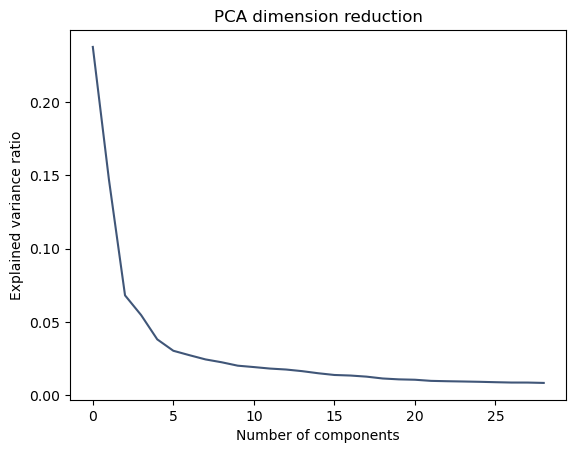

In [67]:
plt.figure()
plt.plot(np.arange(0,my_pca.n_components_,1),my_pca.explained_variance_ratio_)
plt.ylabel('Explained variance ratio')
plt.xlabel('Number of components')
plt.title('PCA dimension reduction')
plt.show()

In [68]:
len(my_pca.explained_variance_)

29

In [69]:
my_pca.n_components_

29

In [70]:
pca_results = pd.DataFrame(data=my_pca.components_[0:2],columns=X_train.columns,index=['PCA1','PCA2'])

In [133]:
pca_results.T.abs().sort_values(by='PCA1',ascending=False)

PCA1      PCA2
avg_lap_bottom_speed_corner  0.176193  0.038245
x0_monaco                    0.175086  0.032307
fl_lap_bottom_speed_corner   0.173170  0.035992
avg_gear2_time_fl            0.172694  0.048207
max_max_speed                0.171795  0.015648
...                               ...       ...
x0_leclerc                   0.000707  0.001247
x0_mclaren                   0.000665  0.007084
x0_sainz                     0.000260  0.001035
x0_kevin_magnussen           0.000218  0.000796
x0_sirotkin                  0.000043  0.016348

[126 rows x 2 columns]

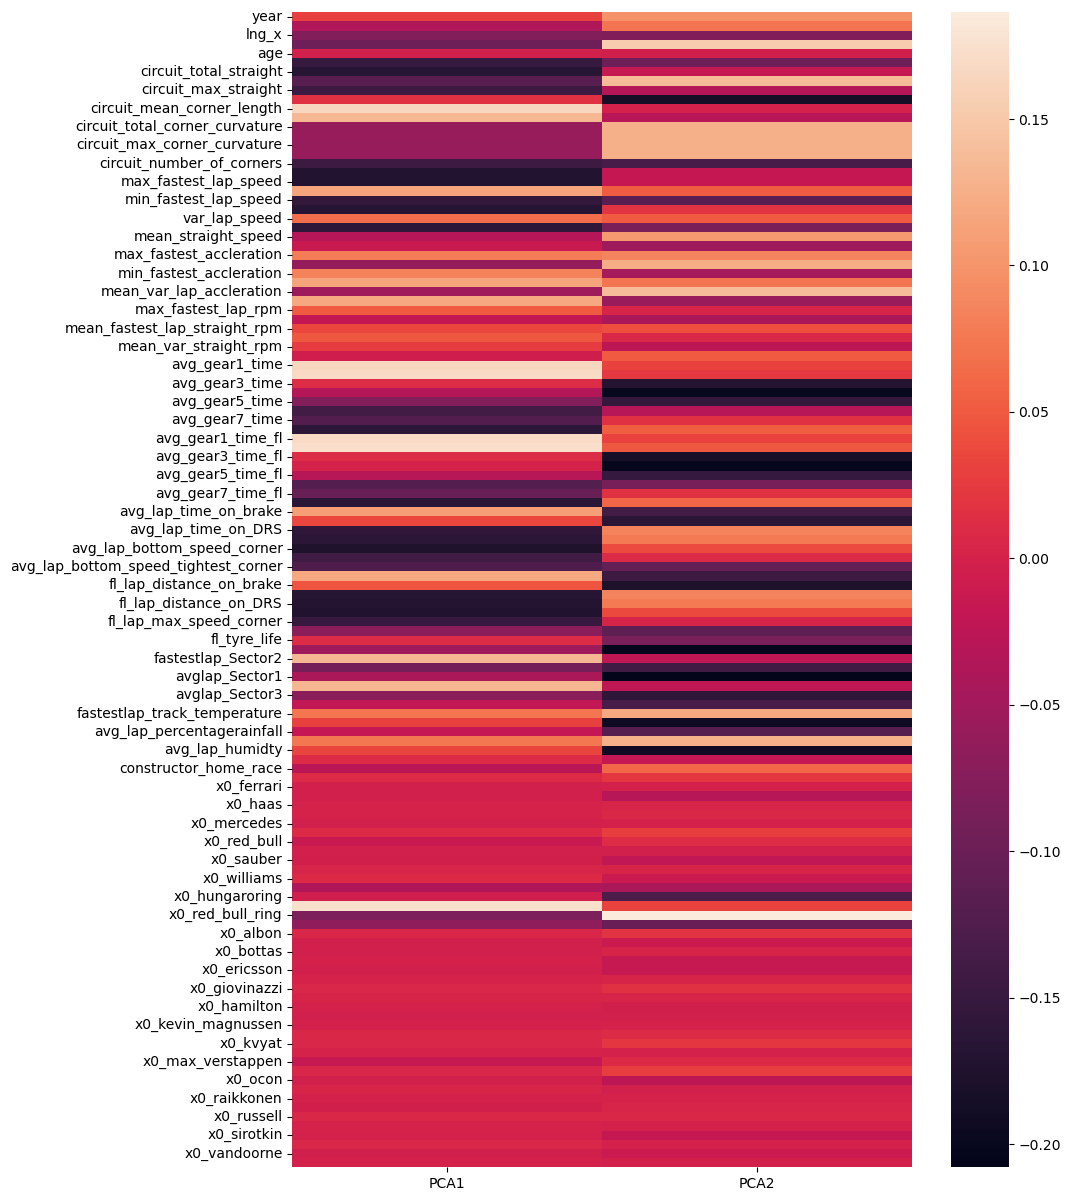

In [72]:
plt.figure(figsize=(10,15))
sns.heatmap(pca_results.T)
plt.show()

In [74]:
RF_results

Random_forest_result
year                      0.001836
lat_x                     0.003584
lng_x                     0.002110
alt                       0.001689
age                       0.020955
...                            ...
x0_sainz                  0.000764
x0_sirotkin               0.000724
x0_stroll                 0.001142
x0_vandoorne              0.001737
x0_vettel                 0.006056

[126 rows x 1 columns]

In [75]:
select_results

SelectKbest_result
year                    1.504459
lat_x                   5.418410
lng_x                   0.832093
alt                     1.907432
age                     6.310242
...                          ...
x0_sainz                0.884632
x0_sirotkin             1.957881
x0_stroll               2.953384
x0_vandoorne            1.286313
x0_vettel               6.415507

[126 rows x 1 columns]

## Summary of Feature Importance
<a id="sumfeature"></a>

In [134]:
all_results = pd.concat([RF_results,select_results,pca_results.T.abs()],axis=1)

In [125]:
#all_results_2 = pd.concat([RF_results/RF_results.max(),select_results/select_results.max(),pca_results.T['PCA1']/pca_results.T['PCA1'].max(),pca_results.T['PCA2']/pca_results.T['PCA2'].max()],axis=1)

In [135]:


scaler=StandardScaler()
all_results_scaled = scaler.fit_transform(all_results)

In [136]:
all_results_2 = pd.DataFrame(data=all_results_scaled,index=all_results.index,columns=all_results.columns)

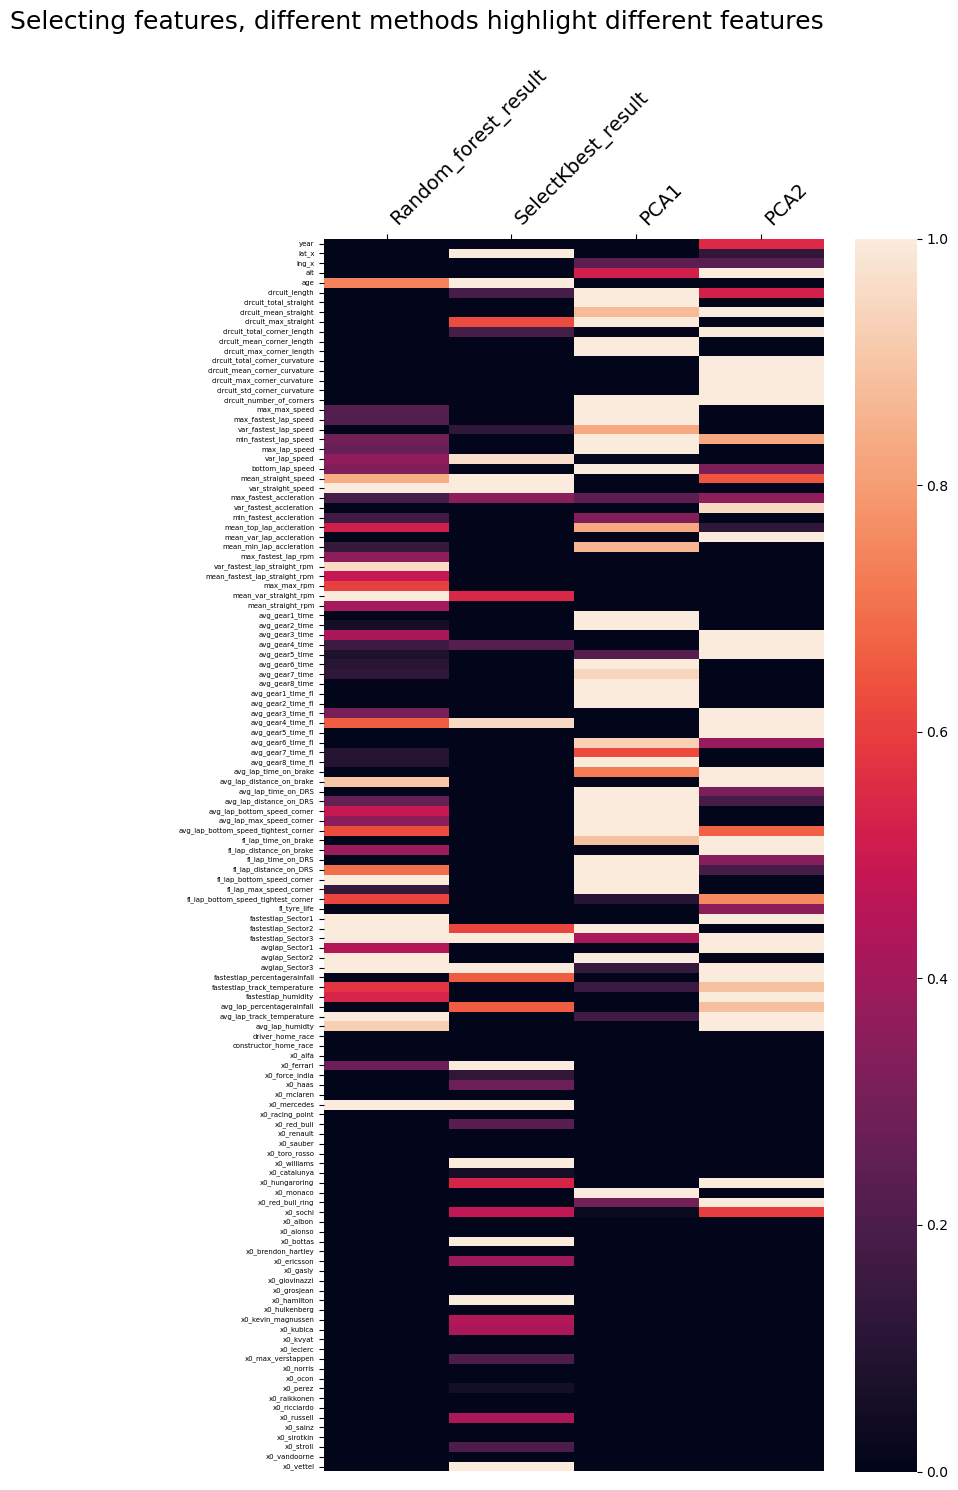

In [188]:
plt.figure(figsize=(8,15))
sns.heatmap(all_results_2, vmax=1, vmin=0)

plt.gca().xaxis.tick_top()
plt.title('Selecting features, different methods highlight different features\n',loc='right',fontsize=18)
plt.xticks(rotation = 45,ha='left',fontsize=14)
plt.yticks(np.arange(0.5,(len(all_results_2.index)+0.5)),labels=all_results_2.index,va="center",fontsize=5)
#plt.gcf().subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)

plt.tight_layout()
plt.savefig('./images/feature_selection_full.jpg',dpi=300,bbox_inches='tight')
plt.show()


# Summary:
<a id="sum"></a>

# Next Steps:
<a id="nextsteps"></a>


# Appendix:
<a id="appendix"></a>

## Logisitic Regression Simple Model

In [46]:

model = LogisticRegression(max_iter=100000)
model.fit(X_train_scaled,y1_train)
print(f'Train Accuracy: {model.score(X_train_scaled, y1_train)}')
#4. Score on testing data
print(f'Test Accuracy: {model.score(X_test_scaled, y1_test)}')

Train Accuracy: 1.0
Test Accuracy: 0.48717948717948717


In [47]:
results = pd.DataFrame(model.coef_,columns=X_train.columns).T
print(results.head(93))

                        0         1         2         3
year            -0.426935  0.436709  0.001756 -0.011530
lat_x            0.137495  0.112581 -0.046936 -0.203140
lng_x            0.078035 -0.036060  0.070898 -0.112874
alt              0.016228 -0.050015  0.015730  0.018057
age              0.415453 -0.034231 -0.160201 -0.221021
...                   ...       ...       ...       ...
x0_mercedes      0.982933 -0.456954 -0.226146 -0.299833
x0_racing_point -0.149316 -0.435752  0.222940  0.362129
x0_red_bull      0.420358  0.130104 -0.258236 -0.292226
x0_renault       0.107282  0.048458  0.038634 -0.194374
x0_sauber       -0.421065 -0.004877  0.117346  0.308597

[93 rows x 4 columns]


In [48]:
print(results[results.all(1)!=0.0].index)

Index(['year', 'lat_x', 'lng_x', 'alt', 'age', 'circuit_length',
       'circuit_total_straight', 'circuit_mean_straight',
       'circuit_max_straight', 'circuit_total_corner_length',
       ...
       'x0_ocon', 'x0_perez', 'x0_raikkonen', 'x0_ricciardo', 'x0_russell',
       'x0_sainz', 'x0_sirotkin', 'x0_stroll', 'x0_vandoorne', 'x0_vettel'],
      dtype='object', length=126)


In [49]:
cs=[0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
results_dict={}
train_acc=[]
test_acc=[]
for c in cs:
    print(c)
    model = LogisticRegression(solver='liblinear',penalty='l1',C=c,max_iter=10000)
    model.fit(X_train_scaled,y1_train)
    print(f'Train Accuracy: {model.score(X_train_scaled, y1_train)}')
    train_acc.append(model.score(X_train_scaled, y1_train))    
    print(f'Test Accuracy: {model.score(X_test_scaled, y1_test)}')
    test_acc.append(model.score(X_test_scaled, y1_test))
    results_dict[c]= pd.DataFrame(model.coef_,columns=X_train.columns).T

0.001
Train Accuracy: 0.25316455696202533
Test Accuracy: 0.23076923076923078
0.01
Train Accuracy: 0.25316455696202533
Test Accuracy: 0.23076923076923078
0.1
Train Accuracy: 0.6772151898734177
Test Accuracy: 0.6410256410256411
1
Train Accuracy: 0.9620253164556962
Test Accuracy: 0.48717948717948717
10
Train Accuracy: 1.0
Test Accuracy: 0.41025641025641024
100
Train Accuracy: 1.0
Test Accuracy: 0.4358974358974359
1000
Train Accuracy: 1.0
Test Accuracy: 0.46153846153846156
10000
Train Accuracy: 1.0
Test Accuracy: 0.46153846153846156


In [50]:
for key in results_dict:
    print(key)
    df=results_dict[key].copy()
    print(df[df.all(1)!=0.0].index)

0.001
Index([], dtype='object')
0.01
Index([], dtype='object')
0.1
Index([], dtype='object')
1
Index(['var_straight_speed', 'max_max_rpm', 'driver_home_race', 'x0_mercedes',
       'x0_kevin_magnussen'],
      dtype='object')
10
Index(['var_straight_speed', 'mean_top_lap_accleration', 'max_max_rpm',
       'fl_tyre_life', 'fastestlap_percentagerainfall', 'driver_home_race',
       'x0_red_bull', 'x0_gasly', 'x0_hamilton', 'x0_hulkenberg',
       'x0_kevin_magnussen', 'x0_sainz'],
      dtype='object')
100
Index(['var_lap_speed', 'var_straight_speed', 'mean_top_lap_accleration',
       'mean_var_lap_accleration', 'max_max_rpm', 'avg_gear4_time',
       'fl_tyre_life', 'avg_lap_percentagerainfall', 'driver_home_race',
       'x0_red_bull', 'x0_gasly', 'x0_hamilton', 'x0_hulkenberg',
       'x0_kevin_magnussen', 'x0_ricciardo', 'x0_sainz'],
      dtype='object')
1000
Index(['var_lap_speed', 'var_straight_speed', 'max_fastest_accleration',
       'min_fastest_accleration', 'mean_top_lap_ac